In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'


!pip install comet_ml
from comet_ml import Experiment

     |████████████████████████████████| 184kB 2.7MB/s 
     |████████████████████████████████| 204kB 8.7MB/s 
     |████████████████████████████████| 409kB 12.3MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=3eea3b626d8c8fc714eb9d5cf29e8dac324c327991701f2b03fdf8e46de7d8d8
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj


### This notebook:
###### 1. Super-quick intro into BaBar DIRC subdetector
###### 2. You create a WGAP-GP GAN

###### BaBar DIRC:
![image](https://www.slac.stanford.edu/BFROOT/www/Detector/DIRC/Gifs/NewDirc.gif)

Detection of Internally Reflected Cherenkov light - a particle identification detector in other words.
We will only generate high-level observables (particle delta log-likelihoods (DLL)) that are obtained after the reconstruction.

We want the generation to be conditional on full kinematics of event: energy, pseudorapidity and the distance between the particle track and DIRC bar side of signal particle. For the data-driven GAN this is just 11-D tabular data.

Data was generated with FastDIRC modified to simulate two particle-events.

Эта тетрадка сделана так, чтобы быть и семинарской тетрадкой и домашкой.

### Задача
A couple of years ago this would have been a paper in a good journal, now should be doable in 20-60 minutes*:
* after Denis Derkach formulated the problem and ёж did all the dirty work of getting training data

Задача в общем виде выглядит как:

Create a conditional **GAN NAME** to generate Y given X


### Задачи:

1. JS-GAN, 1.5 балла
1. [Least Squares GAN](https://arxiv.org/abs/1611.04076), 1 балл
2. WGAN, 1.5 балла
3. WGAN-GP, 2 балла
4. VAE, 1.5 балла
5. Написать метрику с классфикатором, 2 балла
6. Написать обьяснения, 0.5 балла
7. Напишите любой достаточно сложный ган (например [отсюда](https://towardsdatascience.com/gan-objective-functions-gans-and-their-variations-ad77340bce3c)), получите до 5 бонусных баллов

# Данные

Сюда можно не смотреть

In [0]:
import requests
import re

URL_RE = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
url_scrabber = re.compile(r'\s*<input type="hidden" name="downloadURL" '
                          'value="(?P<download_url>' + URL_RE + ')" '
                          'id="downloadURL">')

def get_cernbox_direct_link(url):
    guard_page = requests.get(url)
    for line in guard_page.text.split('\n'):
        match = url_scrabber.match(line)
        if match:
            return match.group('download_url')
    raise RuntimeError("downloadURL not found. Most likely case is a change in CERNBox")


In [0]:
data_url = get_cernbox_direct_link("https://cernbox.cern.ch/index.php/s/hWCh4umYQ0KShjW")
DATA_FILE_NAME = './kaons.hdf'
!wget "$data_url" -O "$DATA_FILE_NAME" -nc


--2020-03-17 10:38:03--  https://cernbox.cern.ch/index.php/s/hWCh4umYQ0KShjW/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.26, 128.142.32.38
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388119563 (370M) [application/x-hdf]
Saving to: ‘./kaons.hdf’

./kaons.hdf         100%[===================>] 370.14M  7.04MB/s    in 58s     

Last-modified header invalid -- time-stamp ignored.
2020-03-17 10:39:05 (6.35 MB/s) - ‘./kaons.hdf’ saved [388119563/388119563]



In [0]:
%matplotlib inline

import copy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data


In [0]:
data = pd.read_hdf(DATA_FILE_NAME)
data.head()


,dll_electron,dll_kaon,dll_muon,dll_proton,dll_bt,particle_one_energy,particle_two_energy,particle_one_eta,particle_two_eta,particle_one_x,particle_two_x
48609366,-0.212708,2.314453,0.404724,-8.901489,-395.625427,5.761642,7.775553,-0.101042,-1.170546,4.806355,11.518691
85800802,-0.975586,7.093811,-0.254272,-118.109131,-125.633118,2.952495,4.515579,-1.027812,1.425283,8.347982,12.483961
48063890,1.210968,1.983414,-0.938339,-3.278305,-201.828049,5.667168,6.883764,0.243560,0.688672,9.765896,1.966456
6662551,-0.033142,1.237122,0.060791,0.109146,-196.228241,6.988772,4.271856,-1.019691,-0.693035,14.185906,15.605581
89492993,0.239120,3.052887,-0.522217,-22.034760,-268.287598,5.403506,8.019310,0.975898,1.015718,6.350332,4.286400


In [0]:
X_COLUMNS = ["particle_one_energy",
             "particle_two_energy",
             "particle_one_eta",
             "particle_two_eta",
             "particle_one_x",
             "particle_two_x"]
Y_COLUMNS = ["dll_electron",
             "dll_kaon",
             "dll_muon",
             "dll_proton",
             "dll_bt"]
assert Y_COLUMNS + X_COLUMNS == list(data.columns)


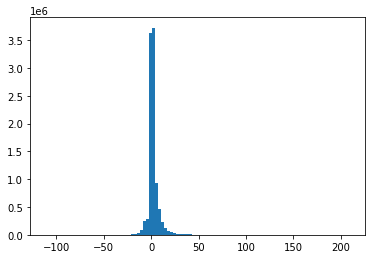

In [0]:
from sklearn.preprocessing import QuantileTransformer
# Please use the sklearn.preprocessing.QuantileTransformer to transform each feature
# into a Gaussian
plt.hist(data.values[:, 1], bins=100);



In [0]:
transformer = QuantileTransformer(1000,'normal')
data_transformed = transformer.fit_transform(data)

Результат должен выглядеть как-то так:
![image.png](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-6/gauss.png)

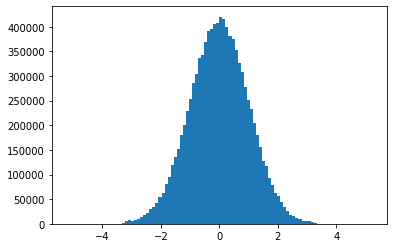

In [0]:
plt.hist(data_transformed[:, 0], bins=100);


In [0]:
train, test = train_test_split(data_transformed, test_size=0.01)
LATENT_DIM = 4 # Размерность "шума"


Здесь нашим генератором и дискриминатором может быть любая полносвязная сеть.

По желанию можно использовать шедулер :)

In [0]:
def get_gen(sz=1000,lr=0.01, gamma = 0.999, activation = nn.LeakyReLU(0.2)):
    gen = nn.Sequential(nn.Linear(LATENT_DIM + len(X_COLUMNS), 256),
    #nn.LeakyReLU(0.2),
    #nn.ReLU(),
    activation,
    nn.Linear(256,512),
    #nn.LeakyReLU(0.2),
    #nn.ReLU(),
    activation,
    nn.Linear(512,256),
    #nn.LeakyReLU(0.2),
    #nn.ReLU(),
    activation,
    nn.Linear(256,len(Y_COLUMNS))).cuda()

    gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lr)
    gen_scheduler = torch.optim.lr_scheduler.StepLR(gen_opt,step_size=sz, gamma=gamma)
    assert gen[0].in_features == LATENT_DIM + len(X_COLUMNS)
    assert gen[-1].out_features == len(Y_COLUMNS)
    return gen, gen_opt, gen_scheduler

In [0]:
def get_disc(sz=1000, lr=0.01,  gamma = 0.1, activation = nn.LeakyReLU(0.2), hid_dim = 1024):
    disc = nn.Sequential(
    nn.Linear(len(X_COLUMNS) + len(Y_COLUMNS), hid_dim),
    #nn.LeakyReLU(0.2),
    #nn.ReLU(),
    activation,
    nn.Linear(hid_dim,hid_dim),
    #nn.LeakyReLU(0.2),
    #nn.ReLU(),
    activation,
    nn.Linear(hid_dim,hid_dim),
    #nn.LeakyReLU(0.2),
    #nn.ReLU(),
    activation,
    nn.Linear(hid_dim,1)).cuda()
    disc_opt = torch.optim.RMSprop(disc.parameters(), lr=lr)
    disc_scheduler = torch.optim.lr_scheduler.StepLR(disc_opt,step_size= sz, gamma = gamma)


    assert disc[0].in_features == data.shape[1]
    assert disc[-1].out_features == 1
    return disc, disc_opt, disc_scheduler

In [0]:
TRAIN_BATCH_SIZE = 512

def sample_real_data(batch_size):
    """
    Inifintly repeats and shuffles the train dataset, outputs the
    result in delicious batches.
    """
    while True:
        dataloader = torch.utils.data.DataLoader(train,
                                                 batch_size=batch_size,
                                                 shuffle=True, drop_last=True)
        for batch in dataloader:
            yield batch
            
infinite_data = sample_real_data(TRAIN_BATCH_SIZE)


In [0]:
# Эта функция семплит данные из вашего генератора
# Принимает на вход x (condition) 
# Возвращает concat(gen_y, x)

def sample_gen_data(x):
    noise = torch.randn((x.shape[0],LATENT_DIM)).cuda()
    gen_input = torch.cat((x,noise),1)
    gen_y = gen(gen_input)
    return torch.cat((gen_y,x),1)


In [0]:
# https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py

def calc_gradient_penalty_classic(critic:torch.nn.Module,
                                  real_data:torch.Tensor,
                                  fake_data:torch.Tensor):
    """
    Computes Gradient Penalty in random interpolates, in its classic form:
    (|∇(D(x)|^2 - 1)^2, x is interpolated between a real and a generated sample
    Args:
      critic: a torch model which gradient needs to be penalised
      real_data[batch_size, n_features]: a sample of real data
      fake_data[batch_size, n_features]: a sample of fake data
    Returns:
      torch.Tensor, scalar, gradient penalty evalute
    """
    assert real_data.shape == fake_data.shape
    alpha = torch.rand(real_data.shape[0], 1)
    alpha = alpha.expand(real_data.size()).cuda()

    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).cuda()
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates,
        grad_outputs=torch.ones(disc_interpolates.size(), device="cuda"),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [0]:
LAMBDA = 10. # for gradient-penalty
def train_disc(gan_type):
    """
    Trains the discriminator for one step. Please note
    this is not a pure function, it captutes the majority of variables
    from the context.
    """
    real_data = next(infinite_data).to("cuda")
    x_gen = next(infinite_data)[:, len(Y_COLUMNS):].to("cuda")
    gen_data = sample_gen_data(x_gen)
    
    if gan_type == "JS":
        err_real = F.binary_cross_entropy_with_logits(disc(real_data),torch.ones(TRAIN_BATCH_SIZE,1).cuda())
        err_fake = F.binary_cross_entropy_with_logits(disc(gen_data),torch.zeros(TRAIN_BATCH_SIZE,1).cuda())
        disc_loss = err_real + err_fake # YOUR CODE
    elif gan_type == "WGAN":
        disc_loss = - torch.mean(disc(real_data) - disc(gen_data))
    elif gan_type == "LSGAN":
        disc_loss = torch.mean((disc(real_data) - torch.ones(TRAIN_BATCH_SIZE,1).cuda())**2 +  disc(gen_data)**2) # YOUR CODE
    elif gan_type == "WGAN-GP":
        disc_loss = torch.mean(disc(gen_data) - disc(real_data))   + LAMBDA*calc_gradient_penalty_classic(disc,real_data,gen_data)
    elif gan_type == "EBGAN":
        disc_loss =  disc(real_data)[0] + F.relu(10 - disc(gen_data)[0])
    else:
        raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP, WGAN, LSGAN")
    
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    if gan_type == "WGAN":
      #weight clipping (doesn't work very good now, maybe it is worth to try changing range)
      for p in disc.parameters():
        p.data.clamp_(-0.05, 0.05)
    return disc_loss


In [0]:
def pull_away_term(x):
  x = F.normalize(x,dim = 1)
  cov = x @ x.t()
  cov = cov - torch.eye(cov.shape[0], device= "cuda") * cov
  return torch.sum(cov**2) / (cov.shape[0]*(cov.shape[0] - 1))

In [0]:
def train_gen(gan_type):
    """Trains generator for one step"""
    real_data_x = next(infinite_data)[:, len(Y_COLUMNS):].to("cuda")
    
    gen_data = sample_gen_data(real_data_x)
    
    if gan_type == "JS":
        gen_loss = F.binary_cross_entropy_with_logits(disc(gen_data),torch.ones(TRAIN_BATCH_SIZE,1).cuda()) # YOUR CODE
    elif gan_type == "WGAN":
        gen_loss =  -disc(gen_data).mean() # YOUR CODE
    elif gan_type == "LSGAN":
        gen_loss = torch.mean((disc(gen_data) - torch.ones(TRAIN_BATCH_SIZE,1).cuda())**2) # YOUR CODE
    elif gan_type == "WGAN-GP":
        gen_loss = -disc(gen_data).mean() # YOUR CODE
    elif gan_type == "EBGAN":
        energy, code = disc(gen_data) 
        gen_loss = energy + pull_away_term(code)

    else:
        raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP, WGAN, LSGAN")
        
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss

In [0]:
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
VALIDATION_INTERVAL = 256
HIST_BINS=100
DATA_HIST_RANGE=[-5, 5]

In [0]:
data_linspace_np = np.linspace(0, 10, num=256, dtype=np.float32)
data_linspace_torch = torch.from_numpy(data_linspace_np)[:, None].cuda()
validation_data = torch.from_numpy(test).cuda()
validation_data_np = test
validation_x = validation_data[:, len(Y_COLUMNS):]

In [0]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [0]:
VALIDATION_INTERVAL = 256
HIST_BINS=100
DATA_HIST_RANGE=[-5, 5]
DISCRIMINATOR_ITERATIONS_PER_STEP = 5
GENERATOR_ITERATIONS_PER_STEP = 1

In [0]:
def train_loop(gan_type = "WGAN", epochs = 5000):
    ks_result_best = 1.
    for i in range(epochs):
        for _ in range(DISCRIMINATOR_ITERATIONS_PER_STEP):
            disc_loss_this_iter = train_disc(gan_type)
        for _ in range(GENERATOR_ITERATIONS_PER_STEP):
            gen_loss_this_iter = train_gen(gan_type)
        experiment.log_metric('loss/discriminator', disc_loss_this_iter.item(), step=i)
        experiment.log_metric('loss/generator', gen_loss_this_iter.item(), step=i)
        gen_scheduler.step()
        if gan_type != "EBGAN":
          disc_scheduler.step()

        if i % VALIDATION_INTERVAL == 0:
            clear_output(True)        
            validation_generated = sample_gen_data(validation_x)
            validation_generated_np = validation_generated.data.cpu().numpy()

            fig, axes_list = plt.subplots(ncols=5, figsize=[6*len(Y_COLUMNS), 6])
            ks_sum = 0.
            for index, ax in enumerate(axes_list):
                ax.hist(validation_generated_np[:, index], range=DATA_HIST_RANGE,
                      alpha=0.5, density=True, label='Generated', bins=HIST_BINS)
                ax.hist(validation_data_np[:, index], range=DATA_HIST_RANGE,
                      alpha=0.5, density=True, label='Real', bins=HIST_BINS)
                ax.set_xlabel(data.columns[index])
                ks_result = ks_2samp(validation_generated_np[:, index],
                                        validation_data_np[:, index])
                ks_sum += ks_result.statistic
                ax.set_title("KS stat = {:.4f}; p-value = {:.4E}".format(*tuple(ks_result)))
            if ks_sum/5. < ks_result_best:
                best_model = copy.deepcopy(gen)
                ks_result_best = ks_sum/5.
            fig.suptitle("Iteration {}".format(i))
            plt.show()
    return best_model

WGAN-GP

In [0]:
LAMBDA = 5.
DISCRIMINATOR_ITERATIONS_PER_STEP = 15
GENERATOR_ITERATIONS_PER_STEP = 1
LATENT_DIM = 2
gen, gen_opt, gen_scheduler = get_gen(sz= 1000, gamma = 0.1)
disc, disc_opt, disc_scheduler = get_disc(sz = 1000, hid_dim= 512)
experiment = Experiment(api_key="dnwaE7rvtITtxwnj54lNinijy", project_name="HWGANs")# YOUR INFO

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/torch-unfunctional/hwgans/426c58b3d33a45d3bf5cf652105f0be3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01       : (33.2, 33.2)
COMET INFO:     sys.cpu.percent.02       : (49.8, 49.8)
COMET INFO:     sys.cpu.percent.avg      : (41.5, 41.5)
COMET INFO:     sys.gpu.0.free_memory    : (9106685952.0, 9106685952.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory    : (2890268672.0, 2890268672.0)
COMET INFO:     sys.ram.total            : (13655232512.0, 13655232512.0)
COMET INFO:     sys.ram.used             : (4111486976.0, 4111486976.0)
COMET INFO: ----------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/torch-unfunctional/hwgans/075b7ecdd8af46fc93ffe51bd77decb2



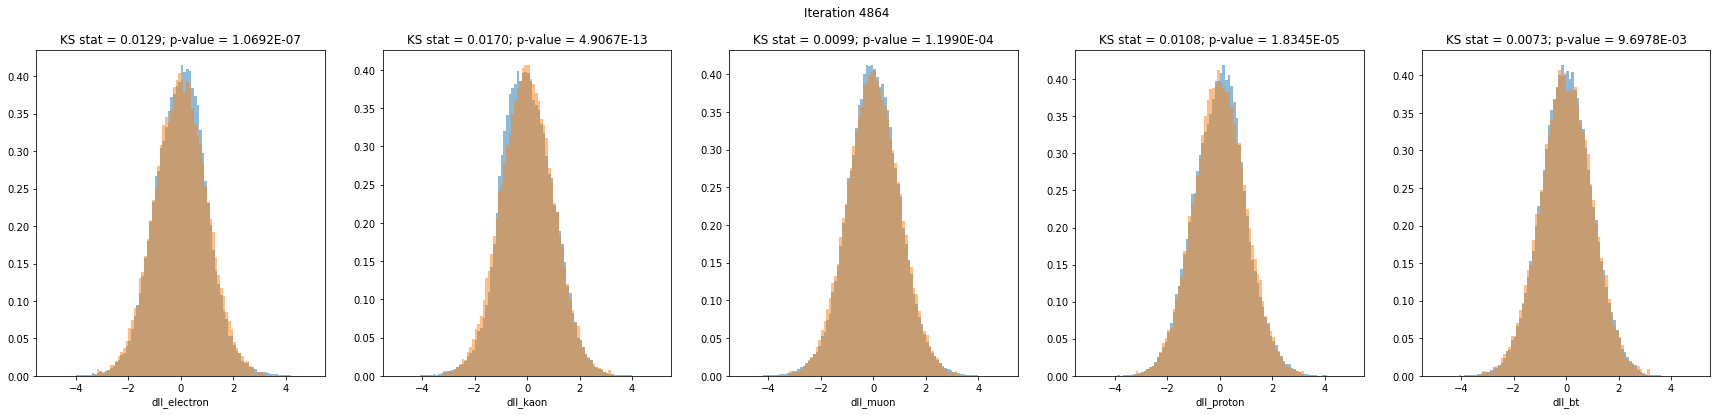

In [0]:
wgan_gp = train_loop(gan_type="WGAN-GP", epochs = 5000)

WGAN

In [0]:
DISCRIMINATOR_ITERATIONS_PER_STEP = 15
GENERATOR_ITERATIONS_PER_STEP = 1
LATENT_DIM = 2
gen, gen_opt, gen_scheduler = get_gen(sz= 1, gamma = 0.995, lr = 0.01)
disc, disc_opt, disc_scheduler = get_disc(sz = 1, gamma = 0.995, activation= nn.ReLU(), hid_dim = 512)
experiment = Experiment(api_key="dnwaE7rvtITtxwnj54lNinijy", project_name="HWGANs")# YOUR INFO

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/torch-unfunctional/hwgans/d67d2e588a244ec8bda6a744df4237f8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3000]                  : (-1829.94873046875, 163.79656982421875)
COMET INFO:     loss/discriminator [5000]    : (-1859.728515625, 8.45644474029541)
COMET INFO:     loss/generator [5000]        : (-123.32859802246094, 1917.397705078125)
COMET INFO:     sys.cpu.percent.01 [3]       : (36.8, 62.6)
COMET INFO:     sys.cpu.percent.02 [3]       : (38.4, 47.6)
COMET INFO:     sys.cpu.percent.avg [3]      : (40.75, 52.0)
COMET INFO:     sys.gpu.0.free_memory [3]    : (13927055360.0, 13927055360.0)
COMET INFO:     sys.gpu.0.gpu_utilization [3]: (0.0, 24.0)
COMET INFO:     sys.gpu.0.total_memory       : (17071734784.0, 17071734784.0)
COMET INFO:     sys.gpu.0.used_memory [3]    : (3144679424.0, 3144679424.0)
COMET INFO:     sys.ram.t

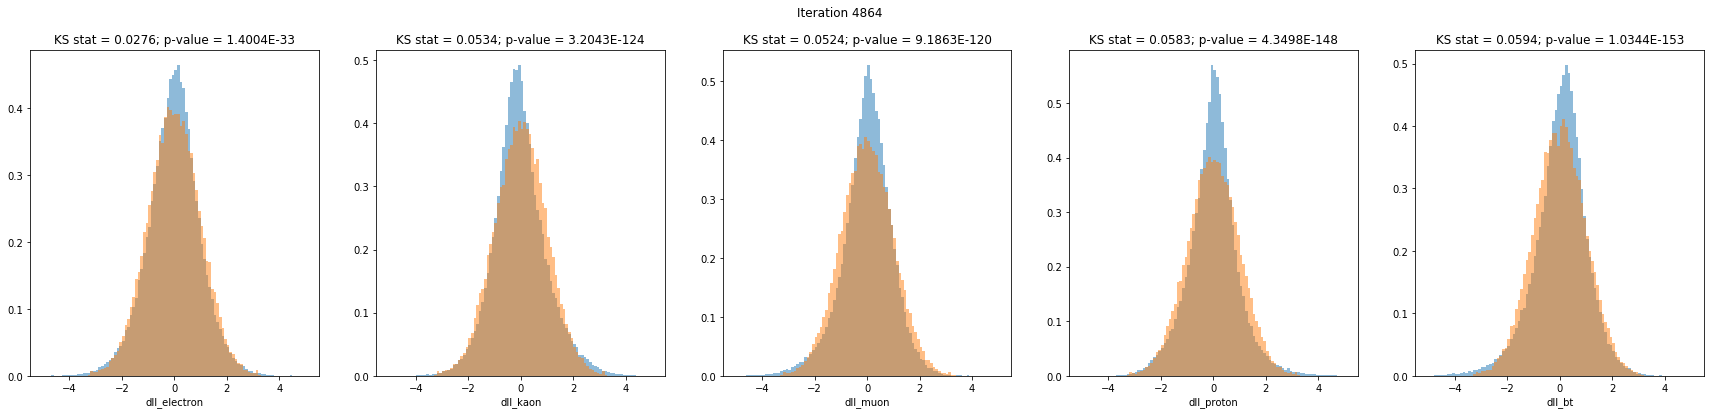

In [0]:
wgan = train_loop(epochs=5000)

LSGAN

In [0]:
DISCRIMINATOR_ITERATIONS_PER_STEP = 1
GENERATOR_ITERATIONS_PER_STEP = 15
VALIDATION_INTERVAL = 256
HIST_BINS=100
DATA_HIST_RANGE=[-5, 5]
LATENT_DIM = 2
MARGIN_D = 200
MARGIN_G = 15
gen, gen_opt, gen_scheduler = get_gen(sz= 1, gamma = 0.995, lr = 0.01, activation=nn.ReLU())
disc, disc_opt, disc_scheduler = get_disc(sz = 1000,activation=nn.ReLU())
experiment = Experiment(api_key="dnwaE7rvtITtxwnj54lNinijy", project_name="HWGANs")# YOUR INFO

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/torch-unfunctional/hwgans/6bf1c50e5b8b41b88ce10bff48111742
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [11000]                  : (0.11529096215963364, 5266.9033203125)
COMET INFO:     loss/discriminator [10000]    : (0.11172151565551758, 20.239192962646484)
COMET INFO:     loss/generator [10000]        : (1.8237354755401611, 66769.296875)
COMET INFO:     sys.cpu.percent.01 [33]       : (1.3, 63.2)
COMET INFO:     sys.cpu.percent.02 [33]       : (1.1, 66.7)
COMET INFO:     sys.cpu.percent.avg [33]      : (1.2000000000000002, 51.900000000000006)
COMET INFO:     sys.gpu.0.free_memory [38]    : (9097248768.0, 9097248768.0)
COMET INFO:     sys.gpu.0.gpu_utilization [38]: (0.0, 49.0)
COMET INFO:     sys.gpu.0.total_memory        : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory [38]    : (2899705856.0, 2899705

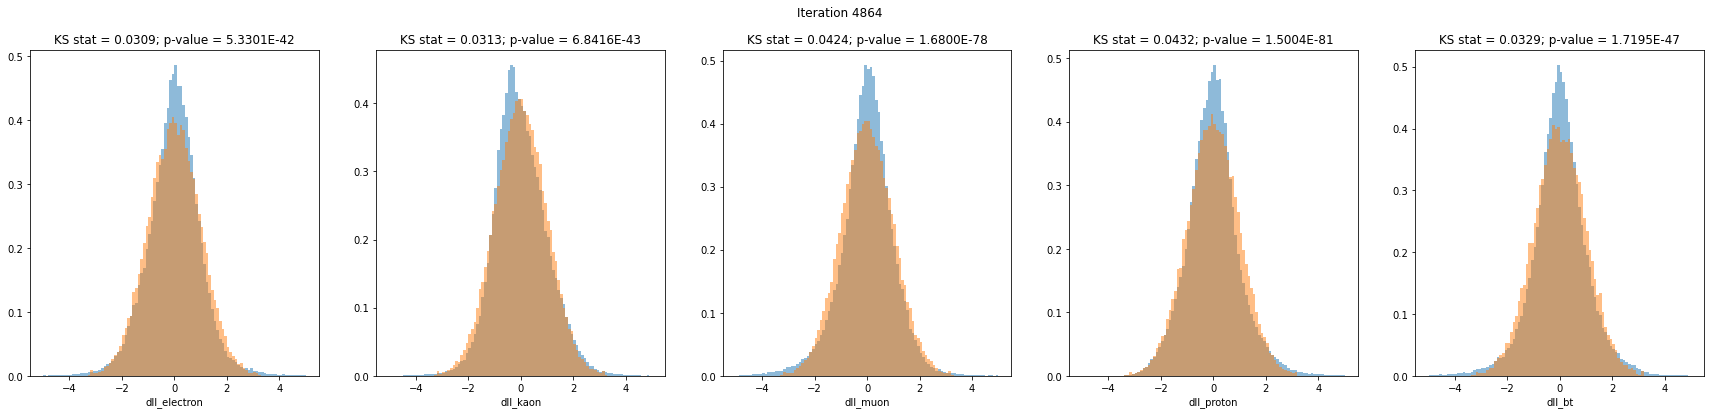

In [0]:
lsgan = train_loop(epochs = 5000, gan_type = "LSGAN")


JSGAN

In [0]:
DISCRIMINATOR_ITERATIONS_PER_STEP = 1
GENERATOR_ITERATIONS_PER_STEP = 10
LATENT_DIM = 2
gen, gen_opt, gen_scheduler = get_gen(sz= 500, gamma = 0.1)
disc, disc_opt, disc_scheduler = get_disc(sz = 1000, hid_dim= 128)
experiment = Experiment(api_key="dnwaE7rvtITtxwnj54lNinijy", project_name="HWGANs")# YOUR INFO

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/torch-unfunctional/hwgans/9bc8f7f227a74b92bdf4d65e1f8ef2c0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [8000]                  : (-695.7998046875, 13.633060455322266)
COMET INFO:     loss/discriminator [5000]    : (-650.3017578125, 0.5214444398880005)
COMET INFO:     loss/generator [5000]        : (-130.48382568359375, 584.6672973632812)
COMET INFO:     sys.cpu.percent.01 [8]       : (9.4, 55.7)
COMET INFO:     sys.cpu.percent.02 [8]       : (6.0, 59.1)
COMET INFO:     sys.cpu.percent.avg [8]      : (7.7, 51.6)
COMET INFO:     sys.gpu.0.free_memory [9]    : (13927055360.0, 13927055360.0)
COMET INFO:     sys.gpu.0.gpu_utilization [9]: (0.0, 24.0)
COMET INFO:     sys.gpu.0.total_memory       : (17071734784.0, 17071734784.0)
COMET INFO:     sys.gpu.0.used_memory [9]    : (3144679424.0, 3144679424.0)
COMET INFO:     sys.ram.total

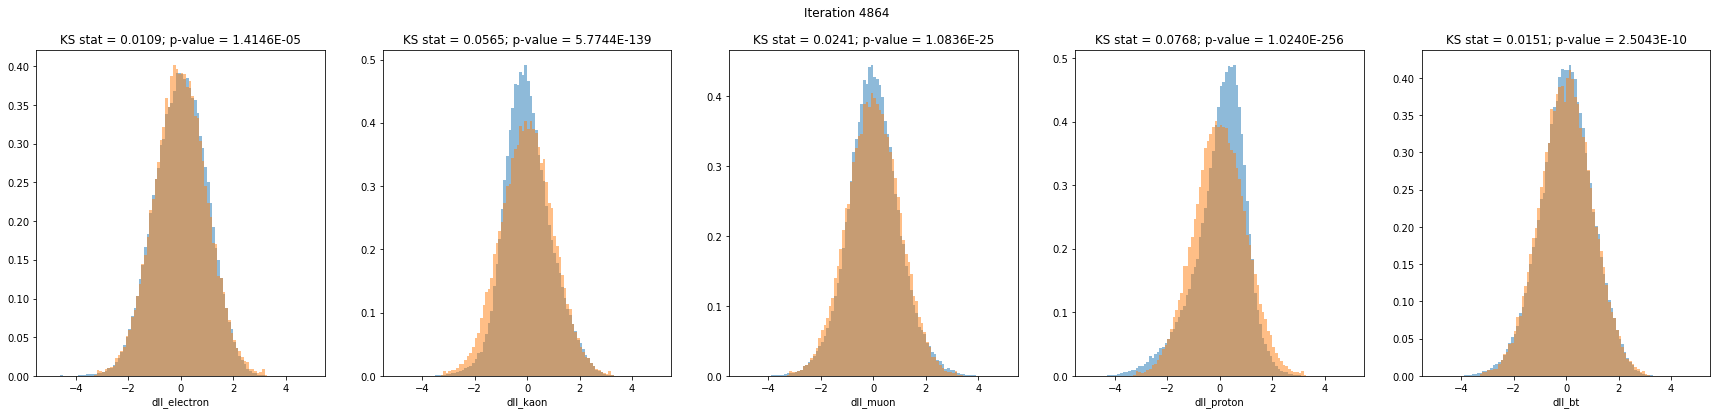

In [0]:
jsgan = train_loop(epochs = 5000, gan_type = "JS")

VAE

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
        nn.Linear(len(X_COLUMNS) + len(Y_COLUMNS), 512, bias = True),
        #nn.BatchNorm1d(512),
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(512,512, bias = True),
        #nn.BatchNorm1d(512),
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(512,256, bias = True),
        nn.ReLU())
        self.mu = nn.Linear(256,LATENT_DIM)
        self.logvar =nn.Linear(256,LATENT_DIM)
        
        
        # Decoder
        self.decoder = nn.Sequential(nn.Linear(LATENT_DIM + len(X_COLUMNS), 512, bias = True),
        #nn.BatchNorm1d(512),
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(512,256, bias = True),
        #nn.BatchNorm1d(256),                            
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(256,256, bias = True),
        #nn.BatchNorm1d(128),                             
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(256,len(Y_COLUMNS)))

    def encode(self, x, y):
        inp = torch.cat((x,y),1)
        out = self.encoder(inp)
        mu = self.mu(out)
        logvar = self.logvar(out)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        

    def decode(self, z, x):
        inp = torch.cat((z,x),1)
        return self.decoder(inp)
        

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, x), mu, logvar
    
    def sample(self, x):
        noise = torch.randn((x.shape[0],LATENT_DIM)).cuda()
        gen_y = self.decode(noise,x)
        return torch.cat((gen_y,x),1)

In [0]:
LATENT_DIM = 2
model = VAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
experiment = Experiment(api_key="dnwaE7rvtITtxwnj54lNinijy", project_name="HWGANs")# YOUR INFO

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/torch-unfunctional/hwgans/1c1eb864cb134ed8a457e9e40ea66c65
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [5500]                   : (0.0, 118230.4296875)
COMET INFO:     loss/discriminator [5000]     : (0.4304782748222351, 179321.703125)
COMET INFO:     loss/generator [5000]         : (0.0, 760.203125)
COMET INFO:     sys.cpu.percent.01 [40]       : (1.4, 54.8)
COMET INFO:     sys.cpu.percent.02 [40]       : (1.3, 51.1)
COMET INFO:     sys.cpu.percent.avg [40]      : (1.4, 52.05)
COMET INFO:     sys.gpu.0.free_memory [45]    : (13927055360.0, 13927055360.0)
COMET INFO:     sys.gpu.0.gpu_utilization [45]: (0.0, 17.0)
COMET INFO:     sys.gpu.0.total_memory        : (17071734784.0, 17071734784.0)
COMET INFO:     sys.gpu.0.used_memory [45]    : (3144679424.0, 3144679424.0)
COMET INFO:     sys.ram.total [40]            : (1365523251

In [0]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x,x,reduction = "sum")
    #BCE  = F.binary_cross_entropy(recon_x,x, reduction = "sum")
    KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

In [0]:
def train_loop_VAE(epochs = 5000):
    ks_result_best = 1.
    for i in range(epochs):
        real_data = next(infinite_data).to("cuda")
        x = real_data[:, len(Y_COLUMNS):]
        y = real_data[:, : len(Y_COLUMNS)]
        model.train()
        optimizer.zero_grad()
        recon_y, mu, logvar = model(x,y)
        mse, kld = loss_function(recon_y, y, mu, logvar)
        loss = mse + kld
        experiment.log_metric('loss/mse', mse.item(), step=i)
        experiment.log_metric('loss/kld', kld.item(), step=i)
        experiment.log_metric('loss/total', loss.item(), step=i)
        loss.backward()
        optimizer.step()
        if i % VALIDATION_INTERVAL == 0:
            clear_output(True)        
            validation_generated = model.sample(validation_x)
            validation_generated_np = validation_generated.data.cpu().numpy()

            fig, axes_list = plt.subplots(ncols=5, figsize=[6*len(Y_COLUMNS), 6])
            ks_sum = 0.
            for index, ax in enumerate(axes_list):
                ax.hist(validation_generated_np[:, index], range=DATA_HIST_RANGE,
                      alpha=0.5, density=True, label='Generated', bins=HIST_BINS)
                ax.hist(validation_data_np[:, index], range=DATA_HIST_RANGE,
                      alpha=0.5, density=True, label='Real', bins=HIST_BINS)
                ax.set_xlabel(data.columns[index])
                ks_result = ks_2samp(validation_generated_np[:, index],
                                        validation_data_np[:, index])
                ks_sum += ks_result.statistic
                ax.set_title("KS stat = {:.4f}; p-value = {:.4E}".format(*tuple(ks_result)))
            if ks_sum/5. < ks_result_best:
                best_model = copy.deepcopy(model)
                ks_result_best = ks_sum/5.
            fig.suptitle("Iteration {}".format(i))
            plt.show()
    return best_model

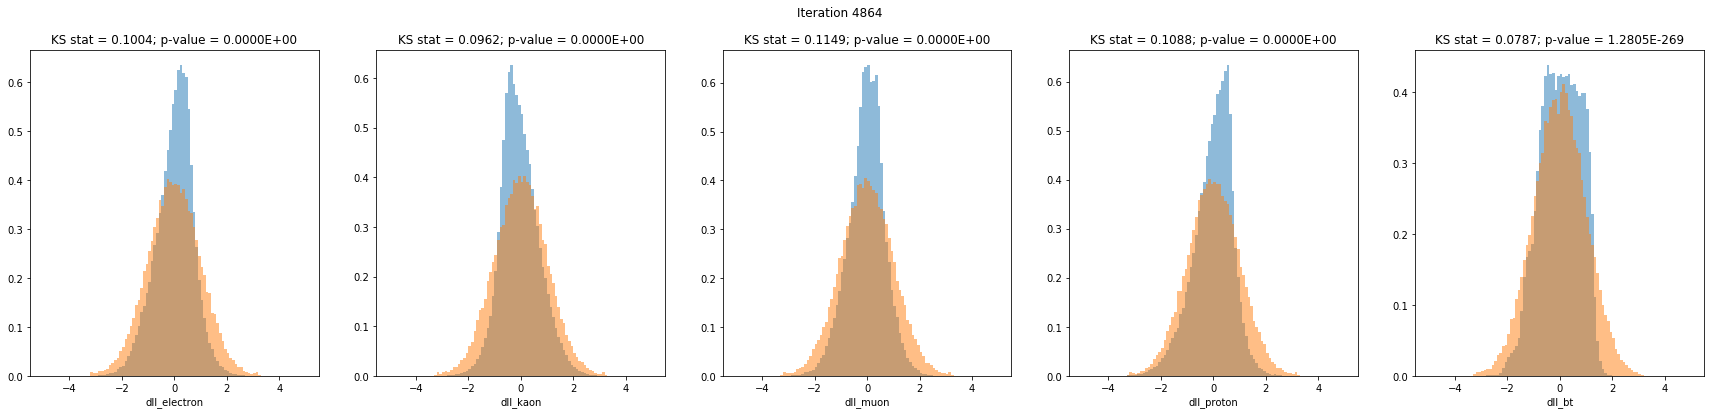

In [0]:
vae = train_loop_VAE(5000)

EBGAN-PT

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
        nn.Linear(len(X_COLUMNS) + len(Y_COLUMNS), 256, bias = True),
        #nn.BatchNorm1d(512),
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(256,128, bias = True),
        #nn.BatchNorm1d(512),
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(128, 5 , bias = True))
        
        # Decoder
        self.decoder = nn.Sequential(nn.Linear(5 + len(X_COLUMNS), 256, bias = True),
        #nn.BatchNorm1d(512),
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(256,256, bias = True),
        #nn.BatchNorm1d(256),                            
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(256,256, bias = True),
        #nn.BatchNorm1d(128),                             
        #nn.LeakyReLU(0.2),
        nn.ReLU(),                             
        nn.Linear(256,len(Y_COLUMNS)))

    def encode(self, x, y):
        inp = torch.cat((x,y),1)
        out = self.encoder(inp)
        return out

    def decode(self, z, x):
        inp = torch.cat((z,x),1)
        return self.decoder(inp)
        

    def forward(self, data):
        y = data[:,:len(Y_COLUMNS)]
        x = data[:,len(Y_COLUMNS):]
        z = self.encode(x, y)
        return torch.mean(torch.norm(self.decode(z, x) - y, p = 2, dim = 1, keepdim= True)), z 

In [0]:
disc = Discriminator().cuda()
disc_opt = torch.optim.Adam(disc.parameters())
DISCRIMINATOR_ITERATIONS_PER_STEP = 10
GENERATOR_ITERATIONS_PER_STEP = 1
LATENT_DIM = 2
gen, gen_opt, gen_scheduler = get_gen(sz= 1000, gamma = 0.5, lr = 0.01)
experiment = Experiment(api_key="dnwaE7rvtITtxwnj54lNinijy", project_name="HWGANs")# YOUR INFO

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/torch-unfunctional/hwgans/901782ec3b23473191e36bf5722bc57d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01       : (1.8, 1.8)
COMET INFO:     sys.cpu.percent.02       : (1.5, 1.5)
COMET INFO:     sys.cpu.percent.avg      : (1.65, 1.65)
COMET INFO:     sys.gpu.0.free_memory    : (9097248768.0, 9097248768.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory    : (2899705856.0, 2899705856.0)
COMET INFO:     sys.ram.total            : (13655232512.0, 13655232512.0)
COMET INFO:     sys.ram.used             : (4543442944.0, 4543442944.0)
COMET INFO: ----------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/torch-unfunctional/hwgans/6bf1c50e5b8b41b88ce10bff48111742



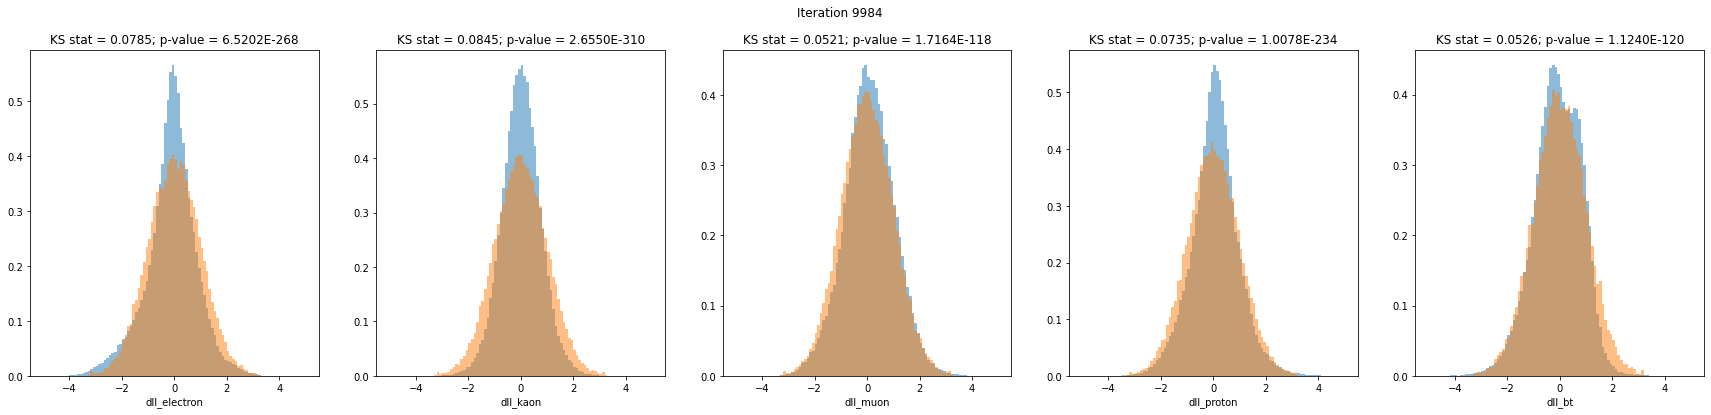

In [0]:
ebgan = train_loop("EBGAN", 10000)

### Метрика с классификатором, 2 балла

Одним из возможных способов подсчета качества вашего гана является качество классификатора обученного на разделение реальных и сгенерированных данных.

1. Возьмите модель, например catboost, xgboost или lightgbm
2. Сгененируйте достаточно большие выборки из реальных и сгенерированных данных (для каждой построенной вами модели)
3. Обучите модель на бинарную классификацию
4. Посчитайте ROC AUC модели, чем ближе к 0.5, тем лучше

In [0]:
!pip install catboost
import sklearn as skl
from catboost import CatBoostClassifier

     |████████████████████████████████| 64.4MB 55kB/s 


In [0]:
def cat_rok_auk(model):
    true_y = validation_data_np[:,:5]
    if isinstance(model,VAE):
        validation_generated = vae.sample(validation_x)
        validation_generated_np = validation_generated.data.cpu().numpy()
        fake_y = validation_generated_np[:,:5]
    else:
        noise = torch.randn((validation_x.shape[0],LATENT_DIM)).cuda()
        gen_input = torch.cat((validation_x,noise),1)
        fake_y = model(gen_input).detach().cpu().numpy()
    true_label = np.ones(100000)
    fake_label = np.zeros(100000)
    true_data = np.concatenate((true_y,true_label.reshape(100000,1)),1)
    fake_data = np.concatenate((fake_y,fake_label.reshape(100000,1)),1)
    np_data = np.concatenate((true_data,fake_data))
    np.random.shuffle(np_data)
    X, y = np_data[:,:5],np_data[:,5]
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    classifier = CatBoostClassifier(
    iterations=100,
    learning_rate=0.03,
    task_type='GPU', verbose = False)
    classifier.fit(X_train,y_train)
    return skl.metrics.roc_auc_score(y_test,classifier.predict_proba(X_test)[:,1]) 

In [0]:
cat_rok_auk(wgan_gp)

0.6415288562989685

In [0]:
cat_rok_auk(wgan)

0.7574340852392022

In [0]:
cat_rok_auk(jsgan)

0.7420429770766981

In [0]:
cat_rok_auk(lsgan)

0.7173973667478358

In [0]:
cat_rok_auk(vae)

0.8429346482258935

In [0]:
cat_rok_auk(ebgan)

0.756129938350395

### Обьяснения, 0.5 балла

1. Напишите, почему для одних ганов метрика выше чем для других.
2. Напишите как можно было бы улучшить те ганы которые у вас есть. 
3. Напишите, какие бы еще модели тут можно было бы попробовать

1)Как мне кажется, многое зависит от подбора гиперпараметров, и при ином подборе могла бы быть немного другая картина. Однако стоит отметить, что WGAN-GP обучается очень стабильно (потому что мы штрафуем за слишком большие градиенты), WGAN - наоборот, дискриминатор либо взрывается либо наоборот тухнет (в зависимости от того, насколько сильно мы ограничим веса). JSGAN - вроде обучался стабильно, и проблема была только не дать дискриманатору задушить генератор. LSGAN - давал большие градиенты за счет MSE, пришлось усилить генератор, чтобы дискриминатор не слишком сильно его шатал (ну или можно было lr поменьше сделать). EBGAN почему-то выдавал данные с перевесом в пользу наиболее вероятных значений. Может быть это связанно с дискриминатором в виде автокодировщика, который сильнее бьет за то, что он вообще не видел в данных и не может реконструировать, чем за то, что он видел, но при другом условии.

2)Я бы использовал ансамбль ганов. Часто во время обучения можно было наблюдать, что по одной фиче ган выдает почти идеально похожее на таргет распределение, в то время как по остальным - сильно промахивается. Можно было бы обучить 5 ганов, каждый из которых давал бы наилучший результат на какой-то одной фиче (по той же KS stat), и потом просто генерить каждым ганом только его лучшую фичу.  

3)Можно использовать, например, kernel density estimation, благо размерность данных сравнительно небольшая